# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

### Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose

from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV

### Datos 

In [2]:
#Aprovecharemos de usar las fechas como índice
try:
    datos = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    datos = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Conociendo los datos

In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Al haber utilizado la columna `datetime` como índice, nos queda solamente una columna de datos numéricos. También observamos que no tenemos datos faltantes.

In [4]:
datos.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Observamos que tenemos un período de separación de 10 minutos.

In [5]:
datos.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Podemos observar que la media y mediana se encuentran muy cerca. Podríamos pensar que los datos que tenemos son una muestra casi equilibrada, pero tenemos valores extremadamente altos. Utilizaremos un `boxplot` para ver como se distribuyen los datos.

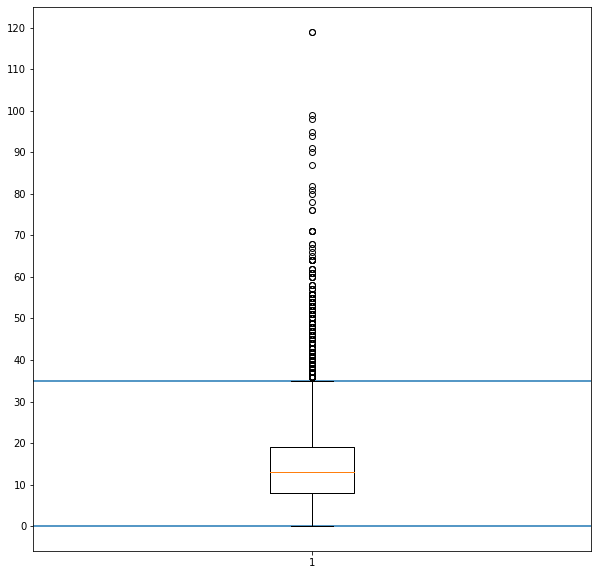

In [6]:
plt.figure(figsize=(10,10))
plt.boxplot(datos)
plt.hlines(35, xmin=0.5, xmax=1.5)
plt.hlines(0, xmin=0.5, xmax=1.5)
plt.yticks(np.arange(0,121,10))
plt.show()

Como mencionado, contamos con valores altos que están fuera de la norma. No eliminaremos estos datos, ya que nos indican el rango normal entre 0 y 35 que se encuentran los viajes cada 10 minutos.

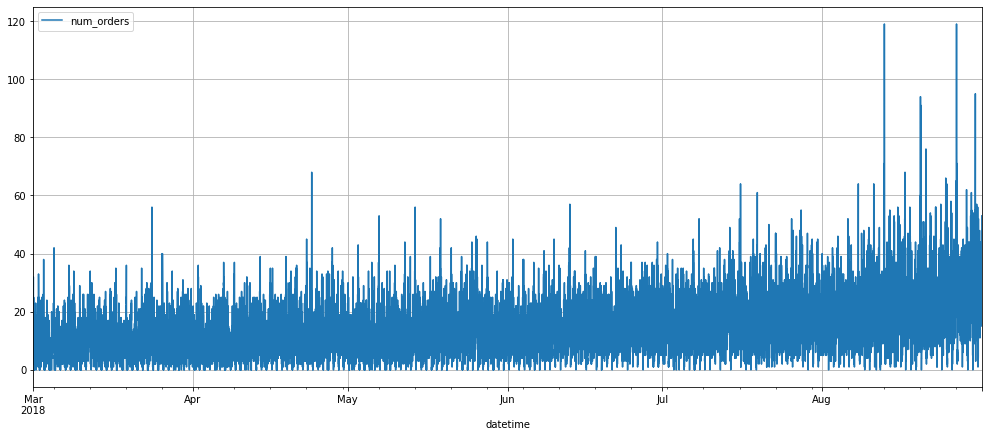

In [7]:
datos.plot(figsize=(17,7), grid=True)
plt.show()

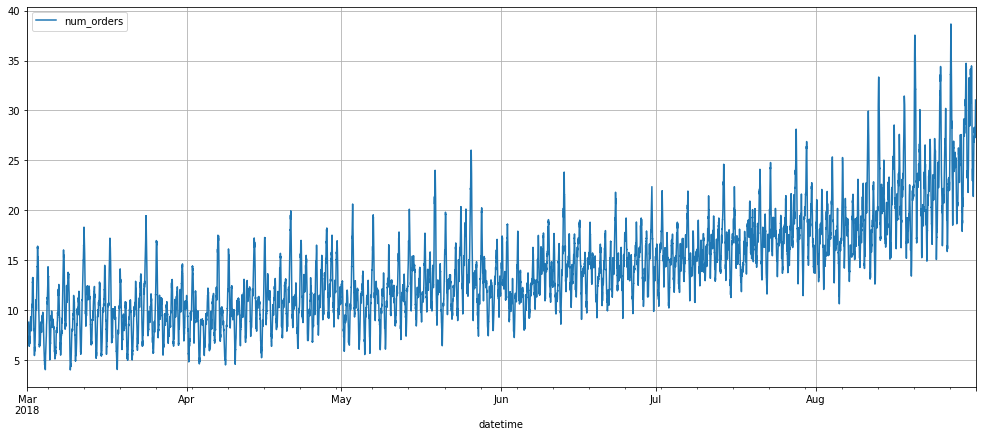

In [8]:
datos.rolling(50).mean().plot(figsize=(17,7), grid=True)
plt.show()

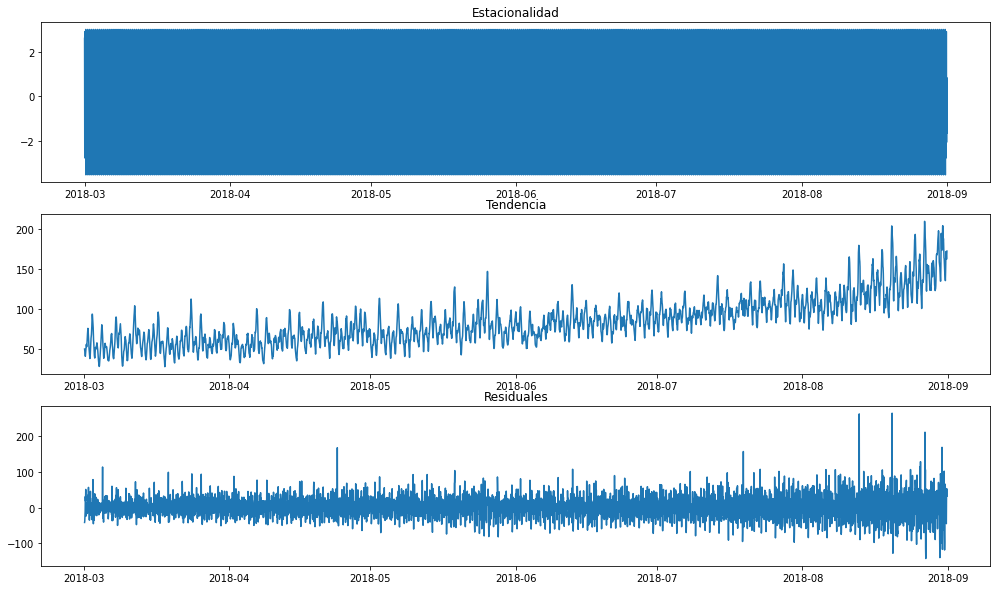

In [9]:
seasonal = seasonal_decompose(datos.resample('1H').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacionalidad')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuales')
plt.show()

In [10]:
# decomposed = seasonal_decompose(data.resample('1H').sum(), period=10, model='additive')
# plt.figure(figsize=(17,10))
# plt.subplot(311)
# decomposed.trend.plot(ax=plt.gca())
# plt.title('Tendencia')
# plt.subplot(312)
# decomposed.seasonal.plot(ax=plt.gca())
# plt.title('Estacionalidad')
# plt.subplot(313)
# decomposed.resid.plot(ax=plt.gca())
# plt.title('Residuales')

# plt.tight_layout()

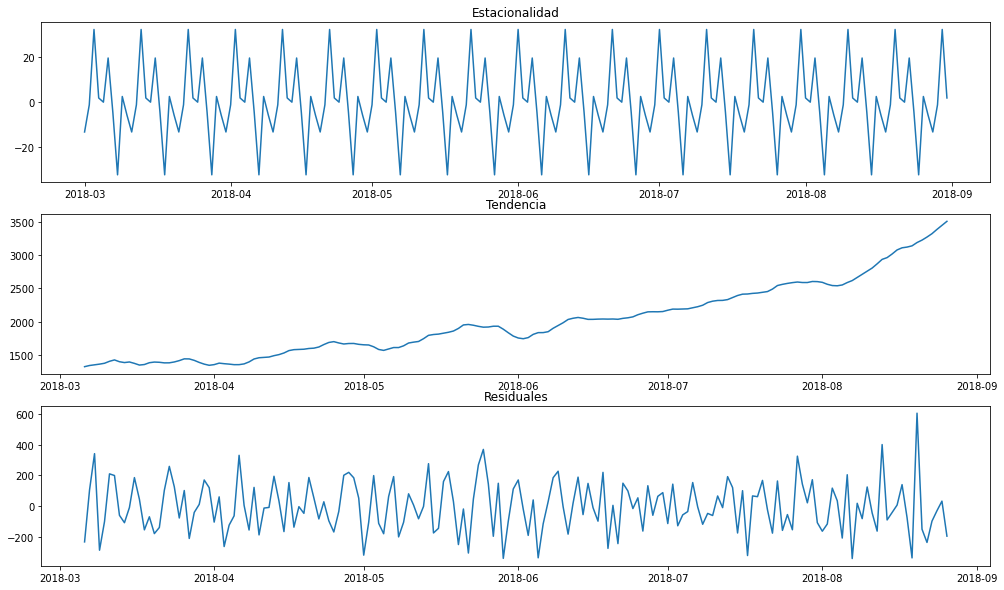

In [11]:
seasonal = seasonal_decompose(datos.resample('1D').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacionalidad')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuales')
plt.show()

Al fijar por día, podemos observar un componente estacional. Es probable que durante una semana, tendremos días con una cantidad de viajes altos y bajos.

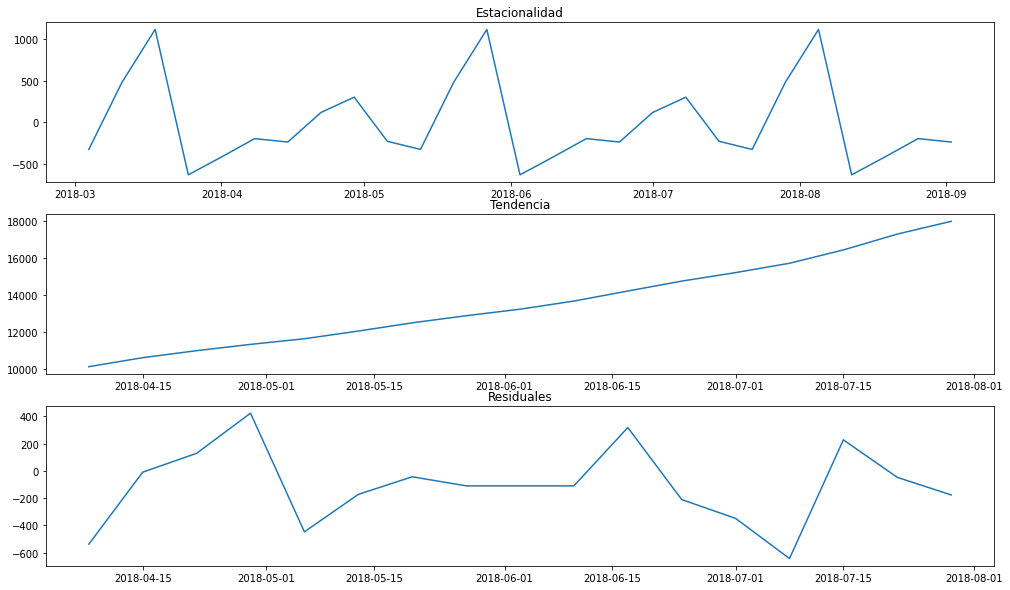

In [12]:
seasonal = seasonal_decompose(datos.resample('1W').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacionalidad')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuales')
plt.show()

## Preparación

Ya que ahora conocemos los datos con los que trabajaremos, podemos pasar a crear nuestras features para los modelos. Pero primero debemos cambiar los rangos de tiempos medidos. Como anteriormente observado, los rangos están en 10 minutos, pero nos solicitan predecir los viajes en la próxima hora. Por lo tanto, debemos cambiar los rangos a 1 hora para poder realizar estas predicciones.

In [13]:
datos_hour = datos.resample('1H').sum()
datos_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [14]:
#definimos nuestra función:

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [15]:
datos_features = make_features(datos_hour, 4, 6)

datos_features.head(10)

,num_orders,hour,month,day,dayofweek,lag1,lag2,lag3,lag4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,5,3,1,3,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,6,3,1,3,6.0,43.0,66.0,71.0,65.833333
2018-03-01 07:00:00,15,7,3,1,3,12.0,6.0,43.0,66.0,47.166667
2018-03-01 08:00:00,34,8,3,1,3,15.0,12.0,6.0,43.0,35.500000


Antes de continuar, eleminaremos los valores NaN.

In [16]:
datos_features.dropna(inplace=True)
datos_features.head()

,num_orders,hour,month,day,dayofweek,lag1,lag2,lag3,lag4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 06:00:00,12,6,3,1,3,6.0,43.0,66.0,71.0,65.833333
2018-03-01 07:00:00,15,7,3,1,3,12.0,6.0,43.0,66.0,47.166667
2018-03-01 08:00:00,34,8,3,1,3,15.0,12.0,6.0,43.0,35.500000
2018-03-01 09:00:00,69,9,3,1,3,34.0,15.0,12.0,6.0,29.333333
2018-03-01 10:00:00,64,10,3,1,3,69.0,34.0,15.0,12.0,29.833333


### Features y Targets

In [17]:
#Fijemos una semilla
rs = RandomState(54321)

Teniendo listo nuestras características y objetivos, podemos proceder con la división de los datos para seguir con nuestros modelos. Nos solicitan dejar un 10% de los datos para el testeo final.

In [18]:
#Separamos los datos de testeo del resto:
rest, test = train_test_split(datos_features, shuffle=False, test_size=0.1)

#Separamos los datos de entrenamiento y validación
train, valid = train_test_split(rest, test_size=0.25, random_state=rs)

#Creamos features y targets para el entrenamiento
features_train = train.drop('num_orders', axis=1)
targets_train = train['num_orders']

#Creamos features y targets para el testeo
features_test = test.drop('num_orders', axis=1)
targets_test = test['num_orders']

#Creamos features y targets para la validación
features_valid = valid.drop('num_orders', axis=1)
targets_valid = valid['num_orders']

#Creamos features y targets para el entrenamiento de la validación
features_rest = rest.drop('num_orders', axis=1)
targets_rest = rest['num_orders']

#Comprobamos el tamaño de los sets
print('Entrenamiento')
print(features_train.shape)
print(targets_train.shape)
print()
print('Validación')
print(features_valid.shape)
print(targets_valid.shape)
print()
print('Test')
print(features_test.shape)
print(targets_test.shape)

Entrenamiento
(2976, 9)
(2976,)

Validación
(993, 9)
(993,)

Test
(441, 9)
(441,)


## Análisis

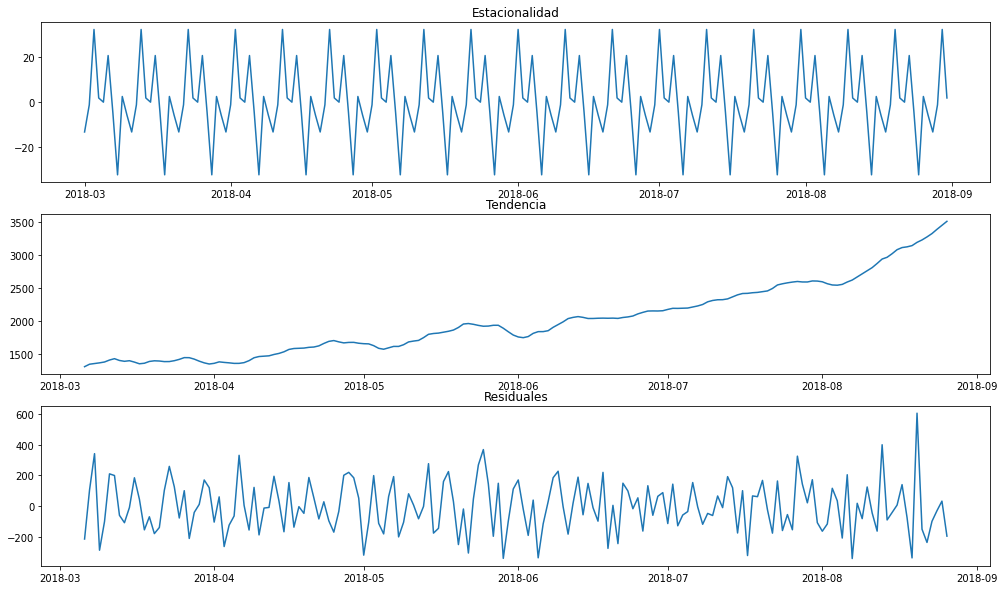

In [19]:
seasonal = seasonal_decompose(datos_features['num_orders'].resample('1D').sum(), model='additive', period=10)

fig, ax = plt.subplots(3, figsize=(17,10))
ax[0].plot(seasonal.seasonal)
ax[0].set_title('Estacionalidad')
ax[1].plot(seasonal.trend)
ax[1].set_title('Tendencia')
ax[2].plot(seasonal.resid)
ax[2].set_title('Residuales')
plt.show()

No observamos gran cambio entre la Estacionalidad y Tendencia de los datos con cambios contra los datos originales. 

## Formación

En esta sección, compararemos diferentes modelos entre ellos e intentaremos obtener el RECM menor posible, además debemos cumplir la condición de que este mismo valor no puede superar un valor de 48.

### Prueba de Cordura con Regresión Lineal

In [20]:
reg = LinearRegression()
reg.fit(features_train, targets_train)
reg_pred = reg.predict(features_valid)

print('RECM: ')
print(mean_squared_error(targets_valid, reg_pred, squared=False))

RECM: 
31.64438041215667


Observando el RECM del modelo de Regresión Lineal superó nuestro valor máximo permitido. Seguiremos con nuestros otros modelos para ver su valor de Raíz del Error Cuadrádico Medio.

### RandomForestRegressor

In [25]:
# Definir los hiperparámetros a probar
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_leaf': [3, 4, 5, 6, 7]
}

# Crear el modelo de Bosque Aleatorio
model = RandomForestRegressor(random_state=rs)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=make_scorer(mean_squared_error, squared=False))

# Definir una función para realizar la búsqueda de hiperparámetros
def run_grid_search():
    grid_search.fit(features_train, targets_train)

#Ejecuta la búsqueda de hiperparámetros    
run_grid_search()    

# Obtener los mejores hiperparámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprimir los mejores hiperparámetros y el mejor score
print('Mejores hiperparámetros:', best_params)
print('Mejor RECM:', best_score)

Mejores hiperparámetros: {'max_depth': 3, 'min_samples_leaf': 3}
Mejor RECM: 27.39313481255578


In [26]:
# Utilizar los mejores hiperparámetros en el modelo
best_forest = RandomForestRegressor(random_state=rs, max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'])

# Entrenar el modelo con los mejores hiperparámetros
best_forest.fit(features_train, targets_train)

# Realizar predicciones utilizando el modelo entrenado
f_pred = best_forest.predict(features_valid)

# Calcular el score final
score = mean_squared_error(targets_valid, f_pred, squared=False)

print()
print('Mejor RECM:', score)




Mejor RECM: 30.15018935235162


In [27]:
#Creamos una variable para añadirla a la lista vacía
error_test_bosque = mean_squared_error(targets_valid, f_pred, squared=False)

Si bien, este modelo toma un poco más de tiempo en ejecutar, podemos observar que el resultado es mejor que el de la Regresión Lineal. Veremos si podremos seguir mejorando con el resto de los modelos.

In [28]:
#Creamos una lista vacía para poder juntar todos los modelos en dicha lista
resultados_modelos = []
#Agregamos los resultados en nuestra lista vacía
resultados_modelos.append({
    'modelo' : 'RandomForestRegressor',
    'error de test' : error_test_bosque    
})

### CatBoost

In [29]:
cat = CatBoostRegressor(iterations=200, silent=True)
cat.fit(features_train, targets_train, eval_set=(features_valid, targets_valid))
cat_pred = cat.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, cat_pred, squared=False))



RECM:
24.50200199425699


Observamos que el modelo CatBoost mejoró nuestro RECM, comparado con los dos modelos anteriores.

In [30]:
#Creamos una variable para añadirla a la lista vacía
error_catboost = mean_squared_error(targets_valid, cat_pred, squared=False)
#Agregamos los resultados en nuestra lista vacía
resultados_modelos.append({
    'modelo' : 'CatBoostRegressor',
    'error de test' : error_catboost    
})

### LightGBM

In [31]:
lgbm = lgb.LGBMRegressor(random_state = rs)
lgbm.fit(features_train, targets_train, eval_metric = 'RMSE', eval_set=(features_valid, targets_valid))
lgbm_pred = lgbm.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, lgbm_pred, squared=False))



[1]	valid_0's rmse: 38.0601	valid_0's l2: 1448.57
[2]	valid_0's rmse: 36.271	valid_0's l2: 1315.59
[3]	valid_0's rmse: 34.8484	valid_0's l2: 1214.41
[4]	valid_0's rmse: 33.6133	valid_0's l2: 1129.85
[5]	valid_0's rmse: 32.4241	valid_0's l2: 1051.32
[6]	valid_0's rmse: 31.5128	valid_0's l2: 993.057
[7]	valid_0's rmse: 30.5293	valid_0's l2: 932.036
[8]	valid_0's rmse: 29.7774	valid_0's l2: 886.695
[9]	valid_0's rmse: 29.1271	valid_0's l2: 848.39
[10]	valid_0's rmse: 28.6212	valid_0's l2: 819.173
[11]	valid_0's rmse: 28.141	valid_0's l2: 791.915
[12]	valid_0's rmse: 27.7944	valid_0's l2: 772.531
[13]	valid_0's rmse: 27.5102	valid_0's l2: 756.809
[14]	valid_0's rmse: 27.1884	valid_0's l2: 739.208
[15]	valid_0's rmse: 26.8922	valid_0's l2: 723.192
[16]	valid_0's rmse: 26.4948	valid_0's l2: 701.973
[17]	valid_0's rmse: 26.2352	valid_0's l2: 688.284
[18]	valid_0's rmse: 26.02	valid_0's l2: 677.038
[19]	valid_0's rmse: 25.832	valid_0's l2: 667.292
[20]	valid_0's rmse: 25.6968	valid_0's l2: 660

El modelo LightGBM ha obtenido el mejor valor de RECM, por muy poco está por debajo de CatBoost.

In [32]:
#Creamos una variable para añadirla a la lista vacía
error_lightgbm = mean_squared_error(targets_valid, lgbm_pred, squared=False)
#Agregamos los resultados en nuestra lista vacía
resultados_modelos.append({
    'modelo' : 'LGBMRegressor',
    'error de test' : error_lightgbm    
})

### Comparación de los modelos
Esta tabla nos ayudará a decidir qué modelo es el mejor para usar en nuestra prueba final

In [33]:
pd.DataFrame(resultados_modelos)

,modelo,error de test
0,RandomForestRegressor,30.150189
1,CatBoostRegressor,24.502002
2,LGBMRegressor,24.369424


## Prueba

Según los resultados mostrados en la tabla anterior, el mejor modelo es el LightGBMRegressor. Por lo tanto, procederemos a ocuparlo para nuestro conjunto de prueba.

In [34]:
lgbm = lgb.LGBMRegressor(random_state=rs)
lgbm.fit(features_rest, targets_rest, eval_metric = 'RMSE', eval_set=(features_test, targets_test))
lgbm_pred = lgbm.predict(features_test)
print('RECM:')
print(mean_squared_error(targets_test, lgbm_pred, squared=False))

[1]	valid_0's rmse: 81.3799	valid_0's l2: 6622.68
[2]	valid_0's rmse: 78.131	valid_0's l2: 6104.45
[3]	valid_0's rmse: 75.2607	valid_0's l2: 5664.17
[4]	valid_0's rmse: 72.3328	valid_0's l2: 5232.04
[5]	valid_0's rmse: 70.0718	valid_0's l2: 4910.05
[6]	valid_0's rmse: 67.9618	valid_0's l2: 4618.81
[7]	valid_0's rmse: 66.2428	valid_0's l2: 4388.11
[8]	valid_0's rmse: 64.7606	valid_0's l2: 4193.93
[9]	valid_0's rmse: 63.0295	valid_0's l2: 3972.71
[10]	valid_0's rmse: 61.3768	valid_0's l2: 3767.11
[11]	valid_0's rmse: 60.3954	valid_0's l2: 3647.6
[12]	valid_0's rmse: 59.2231	valid_0's l2: 3507.38
[13]	valid_0's rmse: 58.3974	valid_0's l2: 3410.25
[14]	valid_0's rmse: 57.5051	valid_0's l2: 3306.84
[15]	valid_0's rmse: 56.771	valid_0's l2: 3222.95
[16]	valid_0's rmse: 55.7254	valid_0's l2: 3105.32
[17]	valid_0's rmse: 54.9269	valid_0's l2: 3016.96
[18]	valid_0's rmse: 54.3335	valid_0's l2: 2952.13
[19]	valid_0's rmse: 53.3507	valid_0's l2: 2846.3
[20]	valid_0's rmse: 53.0217	valid_0's l2: 2

# Conclusión 

Primero analizamos nuestro DataFrame proporcionado, pudiendo definir inmediatamente la columna DateTime como índice y quedando con una sola columna.

Posteriormente, analizamos nuestros datos con resample de 1 Hora y 1 día, viendo como se comportaba nuestra Estacionalidad y Tendencia. Como nos solicitaron que tendremos que predecir la próxima hora, ocupamos el resample de 1 Hora.

Creamos nuestros features y targets para nuestros conjuntos de entrenamiento, validación y testeo, manteniendo un 10% para este último.

Hicimos la prueba de cordura con la Regresión Lineal y posteriormente usamos tres modelos (RandomForestRegressor, CatBoostRegressor y LightGBMRegressor) para comparar nuestros valores de RECM. Llegando a obtener el mejor valor con el LightGBMRegressor. El cual nos dió un RECM de 43.964, pudiendo cumplir con el objetivo de no superar un valor de 48 establecido. 

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48